In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [ ]:
class TradingEnv:
    def __init__(self, prices):
        self.prices = prices
        self.reset()

    def reset(self):
        self.day = 0
        self.holdings = 0
        self.cash = 1000
        return self._get_state()

    def _get_state(self):
        return (self.prices[self.day], self.holdings)

    def step(self, action):
        price = self.prices[self.day]
        if action == 0:  # Buy
            self.holdings += 1
            self.cash -= price
        elif action == 1 and self.holdings > 0:  # Sell
            self.holdings -= 1
            self.cash += price
        elif action == 2:
            pass  # Hold


        self.day += 1
        done = self.day == len(self.prices) - 1
        reward = self.cash + self.holdings * price  # net
        return self._get_state(), reward, done


In [ ]:
class QLearningAgent:
    def __init__(self, state_space, action_space, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.q_table = {}
        self.action_space = action_space
        self.alpha = alpha      # Learning rate
        self.gamma = gamma      # Discount factor
        self.epsilon = epsilon  # Exploration rate

    def _discretize(self, state):
        price, holding = state
        price_bin = int(price // 10)   # Discretize price into bins of size 10
        return (price_bin, int(holding))

    def act(self, state):
        state = self._discretize(state)
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.action_space)

        if random.random() < self.epsilon:
            return random.randint(0, self.action_space - 1)  # Explore
        else:
            return int(np.argmax(self.q_table[state]))        # Exploit

    def learn(self, state, action, reward, next_state):
        state = self._discretize(state)
        next_state = self._discretize(next_state)

        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.action_space)
        if next_state not in self.q_table:
            self.q_table[next_state] = np.zeros(self.action_space)

        max_next = np.max(self.q_table[next_state])
        td_target = reward + self.gamma * max_next
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.alpha * td_error

        self.epsilon = max(0.01, self.epsilon * 0.995) #decaying epsilon after each learning step

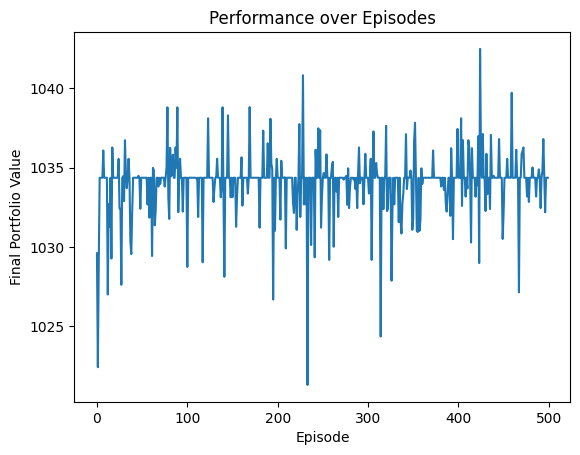

In [ ]:
prices = [100 + np.random.randn() for _ in range(100)]
env = TradingEnv(prices)
agent = QLearningAgent(state_space=None, action_space=3)

portfolio_values = []

for episode in range(500):
    state = env.reset()
    done = False
    while not done:
        #current portfolio value before action
        prev_value = env.cash + env.holdings * env.prices[env.day]

        action = agent.act(state)
        next_state, _, done = env.step(action)

        #new portfolio value after action
        new_value = env.cash + env.holdings * env.prices[env.day]
        reward = new_value - prev_value  # rewrd = diff in portfolio values

        agent.learn(state, action, reward, next_state)
        state = next_state

    final_value = env.cash + env.holdings * env.prices[env.day]
    portfolio_values.append(final_value)
plt.plot(portfolio_values)
plt.xlabel("Episode")
plt.ylabel("Final Portfolio Value")
plt.title("Performance over Episodes")
plt.show()


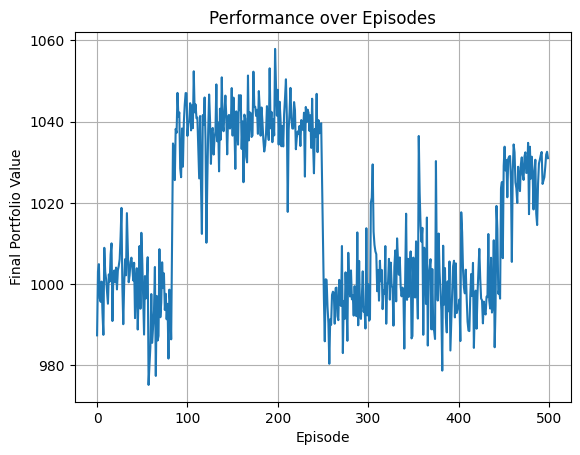

In [ ]:
values = []

for episode in range(500):
    state = env.reset()
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        agent.learn(state, action, reward, next_state)
        state = next_state
    final_price = env.prices[env.day]
    total_value = env.cash + env.holdings * final_price
    values.append(total_value)

plt.plot(values)
plt.xlabel("Episode")
plt.ylabel("Final Portfolio Value")
plt.title("Performance over Episodes")
plt.grid(True)
plt.show()


In [ ]:
#prices = [100 + np.random.randn() for _ in range(100)]
#env = TradingEnv(prices)
#agent = QLearningAgent(state_space=None, action_space=3)

#for episode in range(500):
#    state = env.reset()
#    done = False
#    while not done:
#        action = agent.act(state)
#        next_state, reward, done = env.step(action)
#        agent.learn(state, action, reward, next_state)
#        state = next_state

In [ ]:
class QLearningAgent:
    def __init__(self, state_space, action_space, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.q_table = {}
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.action_space = action_space

    def get_qs(self, state):
        return self.q_table.setdefault(state, [0] * self.action_space)

    def act(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_space - 1)
        return np.argmax(self.get_qs(state))

    def learn(self, state, action, reward, next_state):
        max_next = max(self.get_qs(next_state))
        self.q_table[state][action] += self.alpha * (
            reward + self.gamma * max_next - self.q_table[state][action]
        )